# Motion Tracker

Let's see how this goes.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from model import MotionDataset, Network
import helper

# minmax, minmax_z = helper.get_minmax('train/input.csv', 'test/input.csv')
# print(minmax[0], minmax[1])
# print(minmax_z[0], minmax_z[1])

minmax, minmax_z = helper.get_minmax('train/input.csv', 'test/input.csv')
print(minmax[0], minmax[1])
# print(minmax_z[0], minmax_z[1])

img_width = 256
#randomly rotate or transform the images to help training
train_transforms = transforms.Compose([
#                                         transforms.RandomRotation(30),
#                                         transforms.RandomResizedCrop(256),
                                        transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
#                                            ,transforms.Normalize([0.5, 0.5, 0.5], 
#                                                              [0.5, 0.5, 0.5])
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([
                                       transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
#                                         ,transforms.Normalize([0.5, 0.5, 0.5], 
#                                                              [0.5, 0.5, 0.5])
                                           ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

motions = MotionDataset('train/input.csv', 'train', train_transforms, minmax, minmax_z)
trainloader = DataLoader(motions, batch_size=16, shuffle=True)
img, details, transform, confidences = next(iter(trainloader))

motions_test = MotionDataset('test/input.csv', 'test', test_transforms, minmax, minmax_z)
testloader = torch.utils.data.DataLoader(motions_test, batch_size=16, shuffle=True)
details.shape

[[261.9544 240.1897 260.222  ...   1.       1.       1.    ]
 [258.483  235.5944 257.6013 ...   1.       1.       1.    ]
 [260.6582 239.2072 260.8603 ...   1.       1.       1.    ]
 ...
 [259.3508 242.6804 260.2112 ...   1.       1.       1.    ]
 [260.6462 245.4132 261.6034 ...   1.       1.       1.    ]
 [256.1652 248.9027 255.8225 ...   1.       1.       1.    ]]
0.0 512.0


torch.Size([16, 2])

## Prepare neural network model


In [2]:
model = Network(img_width)
# Set biases to all zeros
#model.hidden.bias.data.fill_(0)
# sample from random normal with standard dev = 0.01
#model.hidden.weight.data.normal_(std=0.01)
print(model)

Network(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=131074, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=66, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


## Train our model

best loss (L1Loss Sum, 0.003, conv4)

```
 Epoch 22/25) Training loss: 6.749771996027863, Test loss: 10.508017539978027
(Epoch 23/25) Training loss: 6.6242278638523295, Test loss: 10.340709686279297
(Epoch 24/25) Training loss: 6.520543051754824, Test loss: 10.395054817199707
```

input contains image (human centered) height, isFacingForward

output contains (x,y) coordinates for 22 body parts
 


In [19]:
from torch import optim, nn
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001)
# criterion = nn.MSELoss() 
criterion = nn.L1Loss(reduction='sum') 
bceloss = nn.BCELoss(reduction='sum')
bceloss_w = 4
print(torch.cuda.get_device_name(0))
train_losses, test_losses = [], []
epochs = 10
device = 'cuda'
model.to(device)
for e in range(epochs):
    running_loss = 0
    for images, details, targets, confidences in trainloader:
        images, details, targets, confidences = images.to(device), details.to(device), targets.to(device), confidences.to(device)
#         print(images.shape, targets.shape)
        #1. forward pass
        ps,ps2 = model.forward(images, details)
#         print(ps2, confidences)
#         print(np.min(ps.cpu().detach().numpy()), np.min(targets.cpu().detach().numpy()))
#         print(np.max(ps.cpu().detach().numpy()), np.max(targets.cpu().detach().numpy()))
#         print(np.min(details.cpu().detach().numpy()))
#         print(np.max(details.cpu().detach().numpy()))
        #2. calculate loss
#         loss = criterion(ps, targets)
        _loss = criterion(ps, targets)
        _bceloss = bceloss(ps2, confidences) / bceloss_w
#         print(_bceloss.item())
        loss = _loss + _bceloss
        #0. Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        #3. run backward propagation
        loss.backward()

        # 4. Take an update step and few the new weights
        optimizer.step()
        running_loss += loss.item()
#         print(loss.item())
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, details, targets, confidences in testloader:
                images, details, targets, confidences = images.to(device), details.to(device), targets.to(device), confidences.to(device)
                ps, ps2 = model.forward(images, details)
                _loss = criterion(ps, targets)
                _bceloss = bceloss(ps2, confidences) / bceloss_w
                test_loss += _loss + _bceloss
#                 test_loss += criterion(ps, targets)

        
        model.train()
        
        test_loss = test_loss/len(testloader)
        train_loss = running_loss/len(trainloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"(Epoch {e}/{epochs}) Training loss: {train_loss}, Test loss: {test_loss}")
        
PATH = 'model.m'
torch.save(model.state_dict(), PATH)

NVIDIA GeForce RTX 3070
(Epoch 0/10) Training loss: 22.502268053450674, Test loss: 22.465417861938477
(Epoch 1/10) Training loss: 21.80450866807182, Test loss: 24.364397048950195
(Epoch 2/10) Training loss: 21.5984012450812, Test loss: 20.965333938598633
(Epoch 3/10) Training loss: 21.188203892617857, Test loss: 20.618938446044922
(Epoch 4/10) Training loss: 20.935728500474173, Test loss: 21.473007202148438
(Epoch 5/10) Training loss: 20.61078759859193, Test loss: 20.889917373657227
(Epoch 6/10) Training loss: 19.994492717509, Test loss: 20.793819427490234
(Epoch 7/10) Training loss: 19.992042262599153, Test loss: 21.13850975036621
(Epoch 8/10) Training loss: 19.540307796226358, Test loss: 20.833444595336914
(Epoch 9/10) Training loss: 19.301521218047952, Test loss: 20.944196701049805


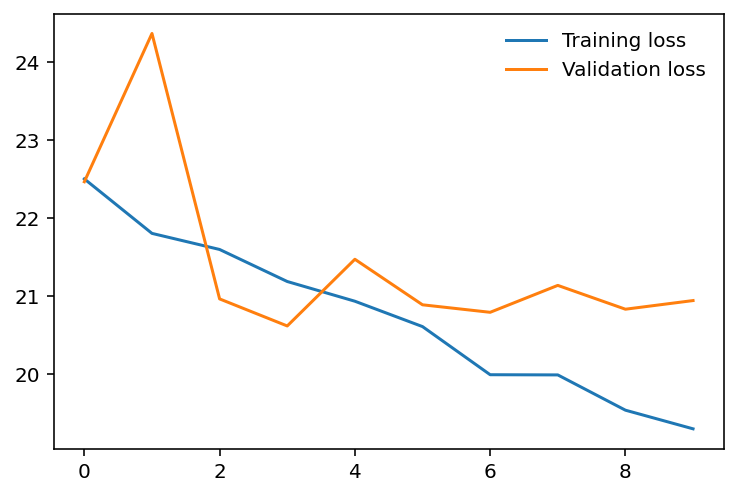

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
test_losses = [test_loss.to('cpu') for test_loss in test_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Use our model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 44])
-0.0040427465 0.024125567
0.7033224 0.7138135
tensor([0.9961, 1.0000])


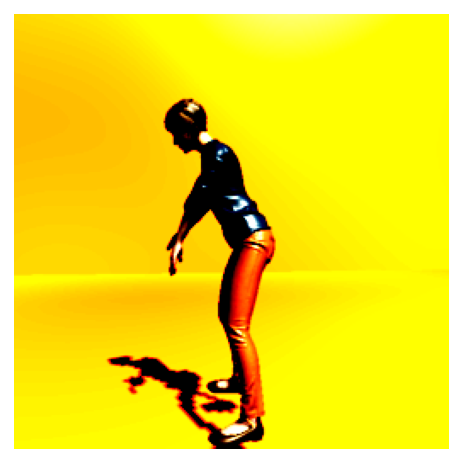

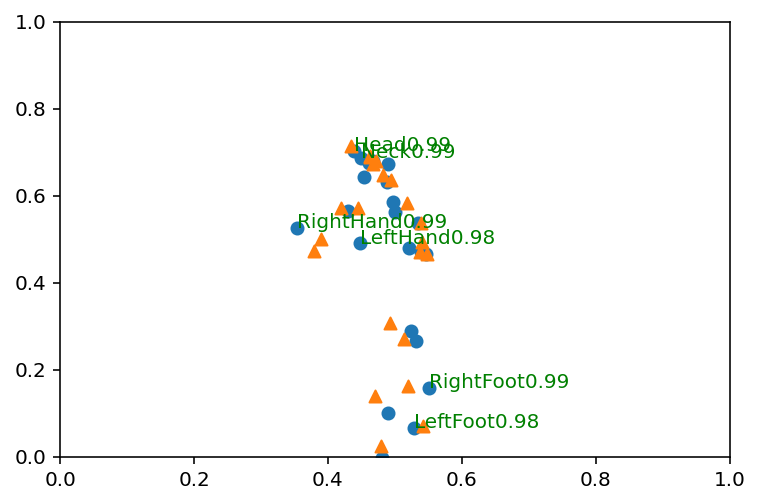

In [25]:
%matplotlib inline
# test_transform = transforms.Compose([transforms.Resize((img_width,img_width)),
#                                 transforms.ToTensor()])

# test_dataset = datasets.ImageFolder('train/', transform=test_transform)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=True)
images, details, labels, confidences = next(iter(testloader))
helper.imshow(images[0], normalize=False)

model.to('cpu')

# img = images[0].view(1, 195075)
# img = torch.zeros(1,120000) + 222

print(labels.shape)
positions = []
positions_expected = []
# Turn off gradients to speed up this part
with torch.no_grad():
    logps, confidences = model.forward(images, details)
    logps_denormalized = logps 
    labels_denormalized = labels 
    print(np.min(logps_denormalized[0].numpy()), np.min(labels_denormalized[0].numpy()))
    print(np.max(logps_denormalized[0].numpy()), np.max(labels_denormalized[0].numpy()))
    print(details[0])
#     print(logps_denormalized[0] * 10 - 5, labels_denormalized[0])
    for body_index in range(22):
        xyz = []
        xyz_e = []
        for pos_index in range(2):
            xyz.append(logps_denormalized[0][body_index*2+pos_index])
            xyz_e.append(labels_denormalized[0][body_index*2+pos_index])
        positions.append(xyz)
        positions_expected.append(xyz_e)
#     print(list(model.parameters()))

positions = np.array(positions)
positions_expected = np.array(positions_expected)
fig = plt.figure()
ax = plt.axes()

# zdata = positions.T[1]
xdata = positions.T[0]
ydata = positions.T[1]
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.scatter(xdata, ydata);

# zdata_e = positions_expected.T[1]
xdata_e = positions_expected.T[0]
ydata_e = positions_expected.T[1]
ax.scatter(xdata_e, ydata_e, marker='^');

for i, pos in enumerate(positions):
    label = None
    if i == 4:
        label = "Neck"
    elif i == 5:
        label = "Head"
    elif i == 9:
        label = "LeftHand"
    elif i == 12:
        label = "LeftFoot"
    elif i == 17:
        label = "RightHand"
    elif i == 20:
        label = "RightFoot"
    if label is not None:
        label = label + "{:.2f}".format(confidences[0][i].item())
        ax.text(pos[0], pos[1], label, None, color="green")

Total distance 0.98848987


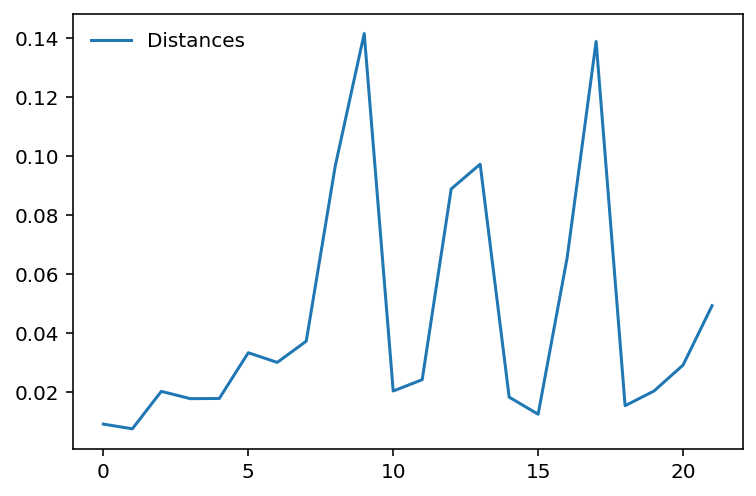

In [24]:
distances = []
for i, pos in enumerate(positions):
    pos_exp = positions_expected[i]
    dist = np.linalg.norm(pos_exp-pos)
    distances.append(dist)

print("Total distance", np.array(distances).sum())
plt.plot(distances, label='Distances')
plt.legend(frameon=False)

## 